In [48]:
import pandas as pd
import numpy as np
from time import time
import dask.dataframe as dd
import matplotlib.pyplot as plt
import matplotlib
import cv2
import tensorflow_hub as hub
from keras.callbacks import ModelCheckpoint
import glob
import tensorflow as tf
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve

%matplotlib inline


In [2]:
#{"username":"hilarytoonnaemeka","key":"0d261ef7f4fee13985b808a11a39ca34"}
import os
os.environ['KAGGLE_USERNAME'] = "hilarytoonnaemeka"
os.environ['KAGGLE_KEY'] = "0d261ef7f4fee13985b808a11a39ca34"
!kaggle datasets download -d nikitarom/planets-dataset

planets-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
! unzip planets-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: test-jpg-additional/test-jpg-additional/file_5499.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_55.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_550.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5500.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5501.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5502.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5503.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5504.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5505.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5506.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5507.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5508.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5509.jpg  
  inflating: test-jpg-additional/test-jpg-additional/fi

In [4]:
PLANET_KAGGLE_ROOT = os.path.abspath("/content/planet/planet")
PLANET_KAGGLE_JPEG_DIR = os.path.join(PLANET_KAGGLE_ROOT, 'train-jpg')
PLANET_KAGGLE_LABEL_CSV = os.path.join(PLANET_KAGGLE_ROOT, 'train_classes.csv')
assert os.path.exists(PLANET_KAGGLE_ROOT)
assert os.path.exists(PLANET_KAGGLE_JPEG_DIR)
assert os.path.exists(PLANET_KAGGLE_LABEL_CSV)

In [5]:
labels_df = pd.read_csv(PLANET_KAGGLE_LABEL_CSV)
print(labels_df.shape)
labels_df.sample(5)

(40479, 2)


,image_name,tags
25003,train_25003,haze primary water
1652,train_1652,clear primary
5057,train_5057,agriculture clear primary
9516,train_9516,clear cultivation primary water
30861,train_30861,clear primary


In [6]:
# Add onehot features for every label
# for label in label_list:
labels_df['tags'] = labels_df['tags'].apply(lambda x: x.split(' '))
# Display head
labels_df.head()

,image_name,tags
0,train_0,"[haze, primary]"
1,train_1,"[agriculture, clear, primary, water]"
2,train_2,"[clear, primary]"
3,train_3,"[clear, primary]"
4,train_4,"[agriculture, clear, habitation, primary, road]"


In [7]:
val = labels_df.memory_usage(index=True).sum()
print(val)

647792


In [12]:
# translating image name to image path
X = labels_df['image_name'].apply(lambda x : PLANET_KAGGLE_JPEG_DIR+'/'+x+'.jpg')
y = labels_df['tags']
X.head(), y.head()

(0    /content/planet/planet/train-jpg/train_0.jpg
 1    /content/planet/planet/train-jpg/train_1.jpg
 2    /content/planet/planet/train-jpg/train_2.jpg
 3    /content/planet/planet/train-jpg/train_3.jpg
 4    /content/planet/planet/train-jpg/train_4.jpg
 Name: image_name, dtype: object,
 0                                    [haze, primary]
 1               [agriculture, clear, primary, water]
 2                                   [clear, primary]
 3                                   [clear, primary]
 4    [agriculture, clear, habitation, primary, road]
 Name: tags, dtype: object)

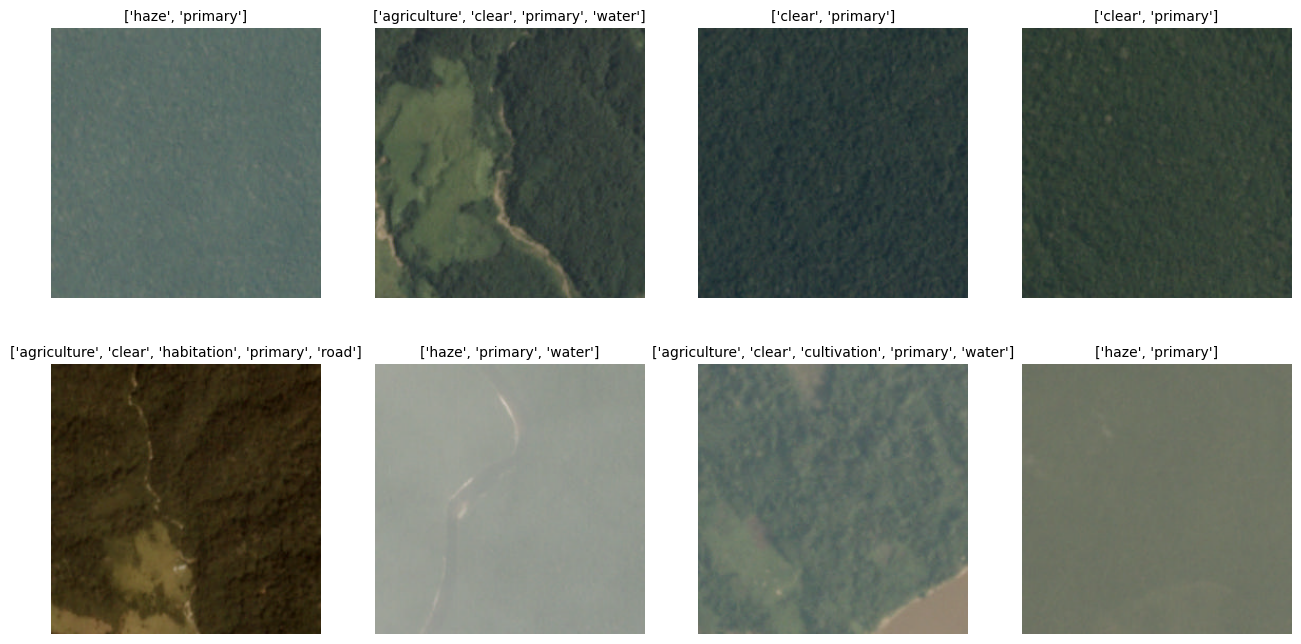

In [16]:
nobs = 8 # Maximum number of images to display
ncols = 4 # Number of columns in display
nrows = nobs//ncols # Number of rows in display


matplotlib.style.use('default')
plt.figure(figsize=(16,4*nrows))
for i in range(nrows*ncols):
    ax = plt.subplot(nrows, ncols, i+1)
    plt.imshow(Image.open(X[i]))
    plt.title(y[i], size=10)
    plt.axis('off')

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X, y,test_size=0.15, random_state=42)

print("Labels:")
mlb = MultiLabelBinarizer()
mlb.fit(y_train)

# Loop over all labels and show them
N_LABELS = len(mlb.classes_)
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i, label))
    
y_train = mlb.transform(y_train)
y_val = mlb.transform(y_val)

Labels:
0. agriculture
1. artisinal_mine
2. bare_ground
3. blooming
4. blow_down
5. clear
6. cloudy
7. conventional_mine
8. cultivation
9. habitation
10. haze
11. partly_cloudy
12. primary
13. road
14. selective_logging
15. slash_burn
16. water


In [24]:
IMG_SIZE = 300 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model

def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label

In [26]:
BATCH_SIZE = 256 # Big enough to measure an F1-score
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations

def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [33]:
train_ds = create_dataset(X_train, y_train)
val_ds = create_dataset(X_val, y_val)

In [34]:
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

In [35]:
##metric function

def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [ ]:
LR = 10000 # Keep it small when transfer learning
EPOCHS = 25

# class KerasWrapper:
#     def __init__(self, model, feat_mean, feat_std):
#         self.model = model
#         self.feat_mean = feat_mean
#         self.feat_std = feat_std
        
#     def predict_proba(self, X):
        
#         preds = self.model.predict((X - self.feat_mean)/self.feat_std)
#         return np.c_[preds, preds]
        
def dask_read_and_incrementally_fit_keras(blocksize):
    
    # reading df with dask
    df_train = dd.read_csv(PLANET_KAGGLE_LABEL_CSV, blocksize=blocksize)
    
    # The feature extractor accepts images of shape (224, 224, 3) and returns a 1280-length vector for each image.
    feature_extractor_url = "https://tfhub.dev/google/efficientnet/b3/feature-vector/1"
    height, width = 300,300
    feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(height,width,CHANNELS))
    
    # We should freeze the variables in the feature extractor layer, so that the training only modifies the new classification layers.
    # Usually, it is a good practice when working with datasets that are very small compared to the orginal dataset the feature extractor was trained on.
    feature_extractor_layer.trainable = False
    
    # creating keras model
    model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dense(1024, activation='relu', name='hidden_layer'),
    tf.keras.layers.Dense(N_LABELS, activation='sigmoid', name='output')
        ])

    model.summary()
    
    model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
      loss=macro_soft_f1,
      metrics=[macro_f1])
    
    filepath="/kaggle/working/model/planet_mobilenet_pretrained-{epoch:02d}-{loss:.4f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='macro_f1', verbose=1, save_best_only=True, mode='max')
    my_callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=8),
        checkpoint,
        tf.keras.callbacks.TensorBoard(log_dir='/kaggle/working/logs'),
        ]

    # loop for number of partitions
    for i in range(df_train.npartitions):
        
        # getting one partition
        part = df_train.get_partition(i).compute(scheduler='synchronous')
        
        part['tags'] = part['tags'].apply(lambda x: x.split(' '))
        X = part['image_name'].apply(lambda x : PLANET_KAGGLE_JPEG_DIR+'/'+x+'.jpg')
        y = part['tags']
        X_train, X_val, y_train, y_val = train_test_split(X, y,test_size=0.2, random_state=42)
        y_train_bin = mlb.transform(y_train)
        y_val_bin = mlb.transform(y_val)

        train_ds = create_dataset(X_train, y_train_bin)
        val_ds = create_dataset(X_val, y_val_bin)
        
        # running partial fit
        history = model.fit(train_ds,
                    epochs=EPOCHS,
                            validation_data=val_ds,
                            callbacks=my_callbacks)
    
    return (model, history)
val = labels_df.memory_usage(index=True).sum()
print(val)
start = time()
model, mem_history_1 = dask_read_and_incrementally_fit_keras(blocksize=(val/4))
print('\nTraining took {}'.format(time()-start))

647792
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1536)              10783528  
                                                                 
 hidden_layer (Dense)        (None, 1024)              1573888   
                                                                 
 output (Dense)              (None, 17)                17425     
                                                                 
Total params: 12,374,841
Trainable params: 1,591,313
Non-trainable params: 10,783,528
_________________________________________________________________
Epoch 1/25
 7/15 [=============>................] - ETA: 6:25 - loss: 0.7795 - macro_f1: 0.2176

In [ ]:
image_name = []
tags = []
imgs = glob.glob("/kaggle/input/planets-dataset/planet/planet/test-jpg/*.jpg")
imgs2 = glob.glob('../input/planets-dataset/test-jpg-additional/test-jpg-additional/*')
imgs = imgs + imgs2
for img in tqdm.tqdm(imgs):
# Read an image from a file
    bgr_image = cv2.imread(img)
    rgb_image = bgr_image[:, :, [2,1,0]]
    # Resize it to fixed shape
    image_resized = cv2.resize(rgb_image, (300, 300))
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0    
    

    img_name = (img.split('/')[-1]).split('.')[0]
    image_name.append(img_name)
#     y_sub = model.predict(image_normalized)
    result = model.predict(image_normalized[np.newaxis,:])
# result.shape
    tags.append(result)

In [ ]:
df_out = pd.DataFrame({'image_name':image_name,'tags':tags})
df_out.head()

In [ ]:
df_out['tags_v2'] = df_out['tags'].apply(lambda x : (x[0] >= 0.7)*1)

In [ ]:
def remapping(x):
    val2 = x*mlb.classes_
    result = ''
    for ele in val2:
        if ele !='':
            result=result+ele+' '
    return result[:-1]
        
df_out['tags_v3'] = df_out['tags_v2'].apply(lambda x : remapping(x))

In [ ]:
df2.to_csv('submission.csv', index=False)